In [294]:
# -*- coding: utf-8 -*-
# Adapted from 2017 Interstellar Technologies Inc. All Rights Reserved.

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics
from math import *

class Orbiter:
    def __init__(self):
        
        #note, if d_ is used, it refers to dimensional quantity in SI units. 
        
        AU = 1.5*10**11;
        mu_sun = (6.67*10**-11)*(2*10**30) #SI units
        year = 3.154*10**7 #seconds
        self.year = year;
        
        #set up non-d params
        
        self.lref = 1*AU; #1 AU
        self.vref = sqrt(mu_sun/self.lref) #v of earths orbit
        self.tref = self.lref/self.vref
        self.aref = (self.vref)**2/self.lref
        self.wref = 1/self.tref;
        self.mref = 1; #kg
        self.Fref = self.mref*self.aref;
        
       
        
        #assign operating limits
        self.d_T_max = 0.5; #assuming 0.5N for vehicle mass of 5000 kg
        
        self.d_tf_max = 2.5*year;
        
        self.d_c = 2020*9.81; #seconds
        
        self.d_dv_max = 6800; #m/s
        
        self.d_m0 = 2500; #kg
        self.d_mp_max = self.d_m0*(1-exp(-self.d_dv_max/self.d_c))
        
        
        #assign initial conditions
        self.d_r0 = 1*AU;
        self.d_c3 = 0*1000*1000 #m^2/s^2;
        self.d_vr0 = 0;
        self.d_vt0 = sqrt(mu_sun/(1*AU)); #assuming prograde
        self.d_w0 =self.d_vt0/self.d_r0; #earths orbital speed
        

        
        self.d_rf = 0.72509758*AU;
        self.d_vrf = 0;
        self.d_final_apogee = 1.65*AU;
        self.d_final_semimajor = (self.d_rf+self.d_final_apogee)/2;        
        self.d_vtf = sqrt(mu_sun*(2/self.d_rf - 1/self.d_final_semimajor)); #vis viva equation at venus apogee.
        self.d_wf = self.d_vtf/self.d_rf;
        
        self.v_v = sqrt(mu_sun/(self.d_rf))/self.vref;
        self.v_vinf = 13.764598574990764*1000/self.vref;
        
        
        #non-dimensionalise
        self.T_max  = self.d_T_max/self.Fref;
        self.r0     = self.d_r0 /self.lref;
        self.vr0    = self.d_vr0/self.vref;
        self.vt0    = self.d_vt0/self.vref;
        self.rf     = self.d_rf /self.lref;
        self.vrf    = self.d_vrf/self.vref;
        self.vtf    = self.d_vtf/self.vref;
        self.tf_max = self.d_tf_max/self.tref;
        self.c      = self.d_c/self.vref;
        self.m0     = self.d_m0/self.mref;
        self.mf_min = (self.d_m0-self.d_mp_max)/self.mref;
        self.c3     = self.d_c3/(self.vref*self.vref)

def dynamics(prob, obj, section):
    r   = prob.states(0, section)
    vr  = prob.states(1, section)
    vt  = prob.states(2, section)
    m   = prob.states(3, section)
    th  = prob.states(4, section)
    
    Tr = prob.controls(0, section)
    Tt = prob.controls(1, section)

    dx = Dynamics(prob, section)
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2 + (Tr/m)
    dx[2] = - vr * vt / r + (Tt/m)
    dx[3] = -((Tr**2+Tt**2)**0.5)/obj.c
    dx[4] = vt/r
    
    return dx()


def equality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    m   = prob.states_all_section(3)
    th  = prob.states_all_section(4)
    
    Tr  = prob.controls_all_section(0)
    Tt  = prob.controls_all_section(1)

    tf  = prob.time_final(-1)

    result = Condition()

    # event condition

    result.equal(r[0], obj.r0)
    #result.equal(vr[0], obj.vr0)
    #result.equal(vt[0], obj.vt0)
    result.equal(th[0],0)
    result.equal(m[0], obj.m0)
    result.equal(r[-1], obj.rf)
    #result.equal(vr[-1], obj.vrf)
    #result.equal(vt[-1],obj.vtf) #has to hit this tangential velocity
    
    #compute venus flyby requirement
    vrf=vr[-1]
    vtf=vt[-1]
    v_c3minus = vrf**2 + (vtf-obj.v_v)**2
    result.equal(v_c3minus, obj.v_vinf**2)

    #result.equal(tf, 1*year/obj.tref)
    result.equal(th[-1], (369.55*tf*obj.tref/year - 59.433)*pi/180)
    
    #result.equal(th[-1],th_venus)

    return result()


def inequality(prob, obj):
    r   = prob.states_all_section(0)
    vr  = prob.states_all_section(1)
    vt  = prob.states_all_section(2)
    m   = prob.states_all_section(3)
    th  = prob.states_all_section(4)
    
    
    Tr = prob.controls_all_section(0)
    Tt = prob.controls_all_section(1)

    tf  = prob.time_final(-1)

    result = Condition()

    # lower bounds
    result.lower_bound(r, 0.5*min(obj.r0,obj.rf))
    result.lower_bound(Tr, -obj.T_max)
    result.lower_bound(Tt, -obj.T_max)
    result.lower_bound(th, 0)
    result.lower_bound(m, obj.mf_min)
    
    result.lower_bound(tf, 0.0)

    # upper bounds
    result.upper_bound(r, 3*max(obj.r0,obj.rf))
    result.upper_bound(np.sqrt(np.square(Tr) + np.square(Tt)), obj.T_max)
    result.upper_bound(Tr, +obj.T_max)
    result.upper_bound(Tt, +obj.T_max)
    
    result.upper_bound(tf, obj.tf_max)
    result.upper_bound(m, obj.m0)
    
    #result.upper_bound(tf,1.1*obj.year/obj.tref)
    
    #compute earth departure bounds
    vr0=vr[0]
    vt0=vt[0]
    
    v_e = obj.vt0;
    
    launchc3 = vr0**2 + (vt0-v_e)**2

    result.lower_bound(launchc3, 0)
    result.upper_bound(launchc3, obj.c3)
    

    return result()


def cost(prob, obj):
    m = prob.states_all_section(3)
    tf = prob.time_final_all_section;
    return -m[-1]


def running_cost(prob, obj):
    return np.square(Tr) + np.square(Tt)



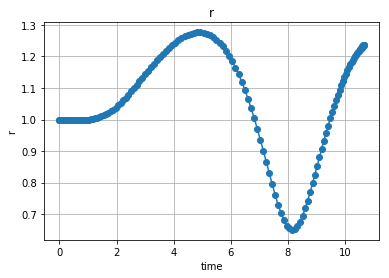

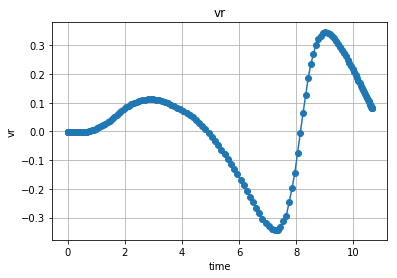

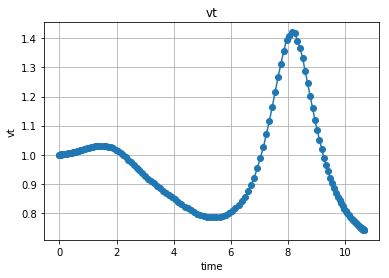

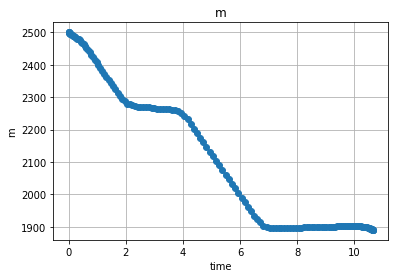

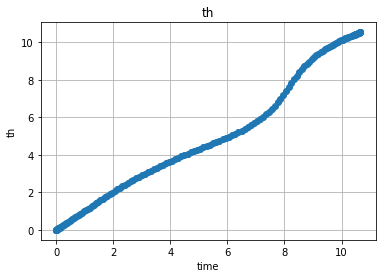

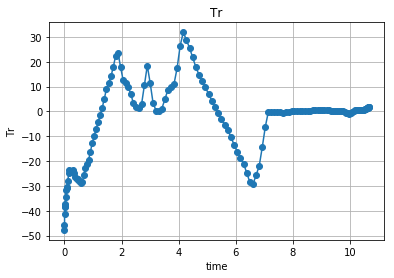

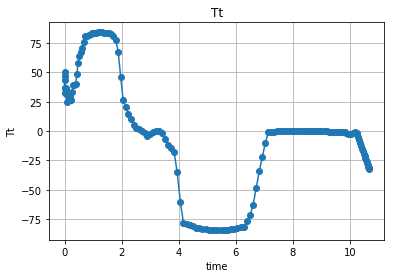

In [296]:

# ========================
plt.close("all")
plt.ion()
# Program Starting Point

obj = Orbiter()


time_init = [0.0, 1.7*obj.year/obj.tref]
n = [150]
num_states = [5]
num_controls = [2]
max_iteration = 5

flag_savefig = False

savefig_dir = "10_Low_Thrust_Orbit_Transfer/"

# ------------------------
# set OpenGoddard class for algorithm determination
prob = Problem(time_init, n, num_states, num_controls, max_iteration)


# ========================
# Initial parameter guess
r_init = Guess.linear(prob.time_all_section, obj.r0, obj.rf)
vr_init = Guess.linear(prob.time_all_section, obj.vr0, obj.vrf)
vt_init = Guess.linear(prob.time_all_section, obj.vt0, obj.vtf)
m_init = Guess.linear(prob.time_all_section, obj.m0, obj.mf_min)
th_init = Guess.linear(prob.time_all_section, 0, 3*2*pi)
Tr_init = Guess.linear(prob.time_all_section, obj.T_max, obj.T_max)
Tt_init = Guess.linear(prob.time_all_section, obj.T_max, obj.T_max)




#set guesses
if 0:
    prob.set_states_all_section(0, r_init)
    prob.set_states_all_section(1, vr_init)
    prob.set_states_all_section(2, vt_init)
    prob.set_states_all_section(3, m_init)
    prob.set_states_all_section(4, th_init)

    prob.set_controls_all_section(0, Tr_init)
    prob.set_controls_all_section(1, Tt_init)
else:
    import pandas as pd
    df = pd.read_csv('OpenGoddard_output.csv')
    t_guess = df["# time"]
    for i in range(5):
        state_temp = df[" state{0:d}".format(i)];
        prob.set_states_all_section(i, np.interp(prob.time[0], t_guess, state_temp))
    for i in range(2):
        control_temp = df[" control{0:d}".format(i)]
        prob.set_controls_all_section(i, np.interp(prob.time[0], t_guess, control_temp))
    


Guess.plot(prob.time_all_section, prob.states_all_section(0), "r", "time", "r")  
Guess.plot(prob.time_all_section, prob.states_all_section(1), "vr", "time", "vr")  
Guess.plot(prob.time_all_section, prob.states_all_section(2), "vt", "time", "vt")  
Guess.plot(prob.time_all_section, prob.states_all_section(3), "m", "time", "m")  
Guess.plot(prob.time_all_section, prob.states_all_section(4), "th", "time", "th")  
Guess.plot(prob.time_all_section, prob.controls_all_section(0), "Tr", "time", "Tr")
Guess.plot(prob.time_all_section, prob.controls_all_section(1), "Tt", "time", "Tt")


In [ ]:


# ========================
# Main Process
# Assign problem to SQP solver
prob.dynamics = [dynamics]
prob.knot_states_smooth = []
prob.cost = cost
#prob.running_cost = running_cost
prob.equality = equality
prob.inequality = inequality


def display_func():
    tf = prob.time_final(-1)
    mf = (prob.states_all_section(3))[-1]
    thf = (prob.states_all_section(4))[-1]
    print("tf: {0:.5f} years".format(tf*obj.tref/obj.year))
    print("mf: {0:.5f} kg".format(mf*obj.mref))
    thf = (thf*180/pi);
    print("thf: {0:.5f} deg".format(thf))

print('lowest mass: ',obj.d_m0-obj.d_mp_max)
prob.solve(obj, display_func, ftol=1e-6)


lowest mass:  1773.8230817240108
---- iteration : 1 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1773.8230817235942
            Iterations: 26
            Function evaluations: 27398
            Gradient evaluations: 26
Iteration limit exceeded
tf: 1.55140 years
mf: 1773.82308 kg
thf: 513.88505 deg

---- iteration : 2 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1773.8219769586794
            Iterations: 26
            Function evaluations: 27429
            Gradient evaluations: 26
Iteration limit exceeded
tf: 1.55458 years
mf: 1773.82198 kg
thf: 515.06266 deg

---- iteration : 3 ----
Iteration limit exceeded    (Exit mode 9)
            Current function value: -1773.8221650381417
            Iterations: 26
            Function evaluations: 27442
            Gradient evaluations: 26
Iteration limit exceeded
tf: 1.55375 years
mf: 1773.82217 kg
thf: 514.75486 deg

---- iteration : 4 ----
Iteration limit exceed

/Users/Devansh/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.


C3 direction:  -0.04394543308063905
C3:  0.000523821234259 km^2/s^2


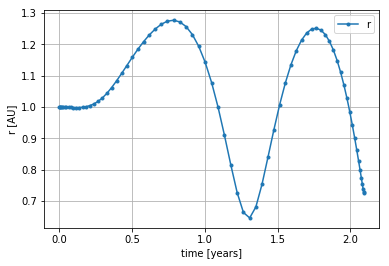

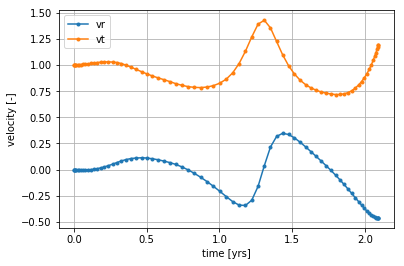

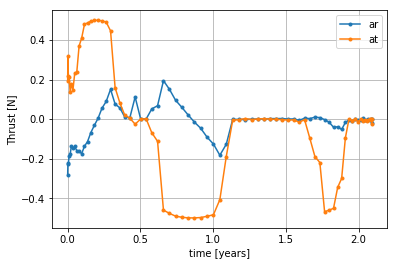

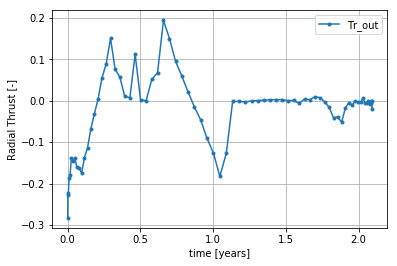

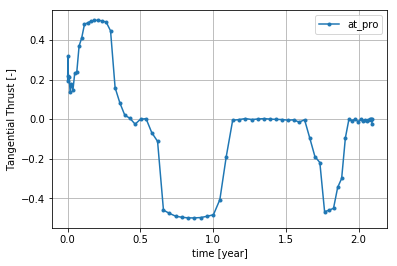

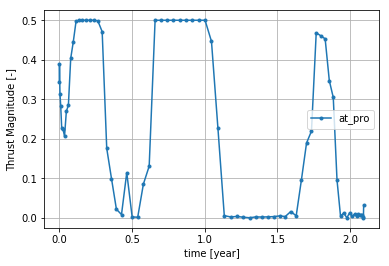

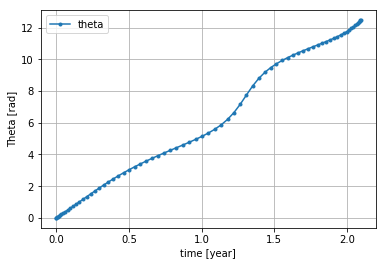

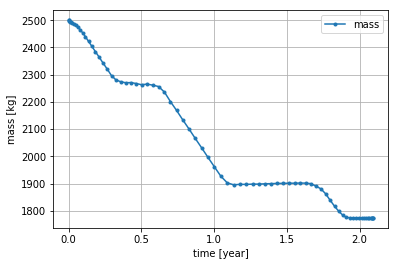

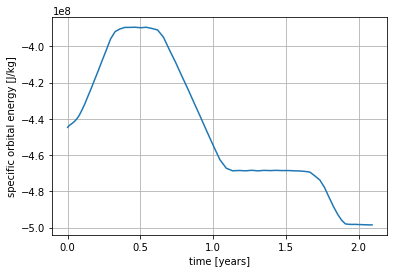

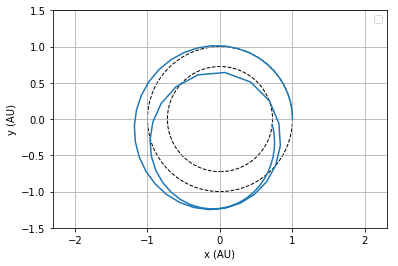

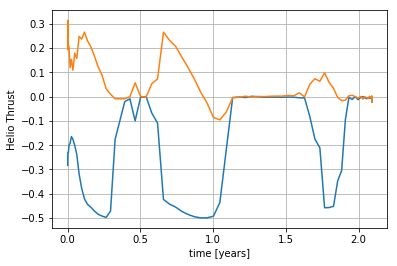

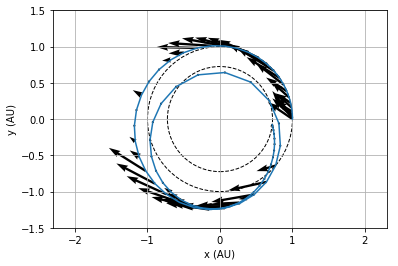

In [286]:

# ========================
# Post Process
# ------------------------
# Convert parameter vector to variable
r = prob.states_all_section(0)
vr = prob.states_all_section(1)
vt = prob.states_all_section(2)
m  = prob.states_all_section(3)
th = prob.states_all_section(4)

Tr = prob.controls_all_section(0)
Tt = prob.controls_all_section(1)

time = prob.time_update()
year = 3.154*10**7;
#year = obj.year #seconds

thrust_mag=np.sqrt(np.square(Tr)+np.square(Tt))
orbital_energy = (vr**2+vt**2)/2 - 1/r

print('C3 direction: ',atan2(vr[0],vt[0])*180/pi)
print('C3: ', (vr[0]**2 + (vt[0]-obj.vt0)**2)*obj.vref*obj.vref/(1000*1000), 'km^2/s^2')


# ------------------------
# Visualizetion
plt.figure()
plt.plot(time*obj.tref/year, r, marker=".", label="r")
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("r [AU]")
plt.legend(loc="best")


plt.figure()
plt.plot(time*obj.tref/year, vr, marker=".", label="vr")
plt.plot(time*obj.tref/year, vt, marker=".", label="vt")
plt.grid()
plt.xlabel("time [yrs]")
plt.ylabel("velocity [-]")
plt.legend(loc="best")
if(flag_savefig): plt.savefig(savefig_dir + "velocity" + ".png")

plt.figure()
plt.plot(time*obj.tref/year, (Tr)*obj.Fref, marker=".", label="ar")
plt.plot(time*obj.tref/year, (Tt)*obj.Fref, marker=".", label="at")
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("Thrust [N]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, Tr*obj.Fref, marker=".", label="Tr_out")
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("Radial Thrust [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, Tt*obj.Fref, marker=".", label="at_pro")
plt.grid()
plt.xlabel("time [year]")
plt.ylabel("Tangential Thrust [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")


plt.figure()
plt.plot(time*obj.tref/year, (Tt**2+Tr**2)**0.5*obj.Fref, marker=".", label="at_pro")
plt.grid()
plt.xlabel("time [year]")
plt.ylabel("Thrust Magnitude [-]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")


plt.figure()
plt.plot(time*obj.tref/year, th, marker=".", label="theta")
plt.grid()
plt.xlabel("time [year]")
plt.ylabel("Theta [rad]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")


plt.figure()
plt.plot(time*obj.tref/year, m*obj.mref, marker=".", label="mass")
plt.grid()
plt.xlabel("time [year]")
plt.ylabel("mass [kg]")
# plt.ylim([-0.02, 0.6])
plt.legend(loc="best")

plt.figure()
plt.plot(time*obj.tref/year, orbital_energy*obj.Fref*obj.lref/obj.mref)
plt.grid()
plt.xlabel('time [years]')
plt.ylabel('specific orbital energy [J/kg]')

#from scipy import integrate
#from scipy import interpolate

#theta = integrate.cumtrapz(vt / r, time, initial=0)
#theta_f = interpolate.interp1d(time, theta)
#r_f = interpolate.interp1d(time, r)
#time_fine = np.linspace(time[0], time[-1], 1000)
#r_fine = r_f(time_fine)
#theta_fine = theta_f(time_fine)

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.plot(r*np.cos(th), r*np.sin(th))
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.legend(loc="best")

plt.show()


#plot the burn direction vector

helioTx = ((Tr)*np.cos(th) - (Tt)*np.sin(th))*obj.Fref
helioTy = ((Tr)*np.sin(th) + (Tt)*np.cos(th))*obj.Fref

fig = plt.figure()
plt.plot(time*obj.tref/year,helioTx,label='helio Tx')
plt.plot(time*obj.tref/year,helioTy, label='helio Ty')
plt.grid()
plt.xlabel('time [years]')
plt.ylabel('Helio Thrust')

plt.show()

fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.plot(r*np.cos(th), r*np.sin(th))
plt.quiver(r*np.cos(th), r*np.sin(th), helioTx,helioTy)
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
if(flag_savefig): plt.savefig(savefig_dir + "trajectry" + ".png")


plt.show()

In [287]:
th[-1]*180/pi

713.91517359432669

In [288]:
time[-1]

13.122137170661855

In [289]:
prob.time_final_all_section()

[13.122137170661855]

In [290]:
#determine how long the transfer will take
final_time = time[-1]
d_final_time = final_time*obj.tref
year = 3.154*10**7 #seconds

print("Transfer time: ",d_final_time/year, "years")
print('initial mass: ', m[0])
print('final mass: ',m[-1])
#determine delta v and mass fraction
d_delv=obj.d_c * (log(m[0]/m[-1]))
print("Required Delta-v: ", d_delv, "m/s")
mpm0=1-exp(-d_delv/(2020*9.81))
print("Propellant mass fraction: ", mpm0)

#final phase angle:
print("Arriving phase: ", th[-1], "rad")
print("Arriving phase: ", 360*((th[-1]/(2*pi))%1))

Transfer time:  2.09267534703 years
initial mass:  2500.0
final mass:  1773.82308172
Required Delta-v:  6800.000000000004 m/s
Propellant mass fraction:  0.2904707673103958
Arriving phase:  12.4601703592 rad
Arriving phase:  353.915173594


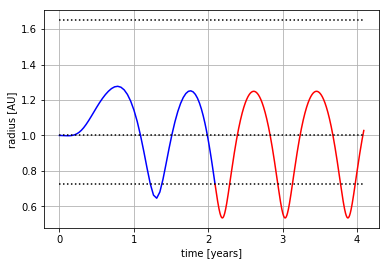

/Users/Devansh/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.


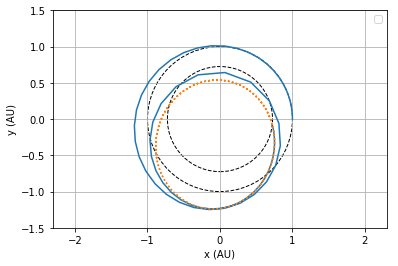

In [291]:
#integrate the dynamics from the end point

#define the passive dynamics
from scipy.integrate import odeint
def passiveDynamics(x,t):
    r = x[0]
    vr = x[1]
    vt = x[2]
    th = x[3]
    
    dx = [0,0,0,0]
    dx[0] = vr
    dx[1] = vt**2 / r - 1 / r**2
    dx[2] = - vr * vt / r
    dx[3] = vt / r
    
    return dx

#integrate using odeint
t_passive = np.linspace(final_time,final_time+2*year/obj.tref,10000)
x_passive = odeint(passiveDynamics,[r[-1],vr[-1],vt[-1],th[-1]],t_passive)

#extract the radial position
r_passive = x_passive[:,0]
th_passive = x_passive[:,3]


#plot the final solution
plt.figure()
plt.plot(time*obj.tref/year, r,'b')
plt.plot(t_passive*obj.tref/year, r_passive,'r')
plt.plot([0,final_time*obj.tref/year + 2],[obj.r0,obj.r0],'k:')
plt.plot([0,final_time*obj.tref/year + 2],[obj.rf,obj.rf],'k:')
plt.plot([0,final_time*obj.tref/year + 2],[obj.d_final_apogee/obj.lref,obj.d_final_apogee/obj.lref],'k:')
plt.grid()
plt.xlabel("time [years]")
plt.ylabel("radius [AU]")

plt.show()


fig = plt.figure()
# plt.plot(r*np.cos(theta), r*np.sin(theta))
plt.plot(r*np.cos(th), r*np.sin(th))
plt.plot(r_passive*np.cos(th_passive),r_passive*np.sin(th_passive),ls=':')
ax = fig.add_subplot(111)
circle0 = plt.Circle((0.0, 0.0), obj.r0, ls="--", fill=False, fc='none')
circlef = plt.Circle((0.0, 0.0), obj.rf, ls="--", fill=False, fc='none')
ax.add_patch(circle0)
ax.add_patch(circlef)
plt.grid()
plt.axis('equal')
plt.ylim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlim((-1.5*max(obj.r0,obj.rf),1.5*max(obj.r0,obj.rf)))
plt.xlabel('x (AU)')
plt.ylabel('y (AU)')
plt.legend(loc="best")

plt.show()


In [292]:
if 1: 
    prob.to_csv();

Completed saving "OpenGoddard_output.csv"


In [267]:
if 0:
    d_t = time*obj.tref/year;
    d_r = r*obj.lref;
    d_vr = vr*obj.vref;
    d_vt = vt*obj.vref;
    d_m  = m*obj.mref;
    d_th = th;
    d_Tr = Tr*obj.Fref;
    d_Tt = Tt*obj.Fref;
    
    df = pd.DataFrame()
    df['Time (yrs)']  = d_t
    df['R (AU)'] = r
    df['Vr (m/s)'] = d_vr
    df['Vt (m/s)'] = d_vt
    df['m (kg)'] = d_m
    df['theta (rad)'] = th
    df['T radial (N)'] = d_Tr
    df['T tangential (N)'] = d_Tt
    
    df.to_csv('Dimensional Output_C3_6_t_2R4yr.csv')
    

In [233]:
mu_sun = (6.67*10**-11)*(2*10**30)

In [234]:
orbital_energy = (vr**2+vt**2)/2 - 1/r

In [235]:
orbital_energy

array([-0.48437389, -0.48437412, -0.48436564, -0.48434137, -0.48430472,
       -0.48426227, -0.48421315, -0.48413944, -0.48405609, -0.48398493,
       -0.48391804, -0.48384824, -0.48374012, -0.48357131, -0.48332074,
       -0.48302139, -0.48270241, -0.48232485, -0.48188374, -0.48133702,
       -0.4805821 , -0.47951912, -0.47842077, -0.47719024, -0.47570688,
       -0.47392914, -0.47226699, -0.4704841 , -0.46845749, -0.46637385,
       -0.46418713, -0.46194533, -0.45982601, -0.45806844, -0.45674311,
       -0.45534715, -0.45334412, -0.45151453, -0.45052643, -0.4497771 ,
       -0.44960797, -0.44890471, -0.44715213, -0.44624777, -0.44603017,
       -0.44600798, -0.44595564, -0.44587296, -0.44563341, -0.44544194,
       -0.44546979, -0.44585666, -0.44660127, -0.44755074, -0.44886584,
       -0.45048189, -0.45228692, -0.45423085, -0.45629692, -0.45845564,
       -0.46069721, -0.46300093, -0.46535726, -0.46775527, -0.47018458,
       -0.4726387 , -0.47510913, -0.4775938 , -0.4800836 , -0.48

In [85]:
m[0]-m[-1]

436.87769774265234

In [86]:
sqrt(mu_sun/(1*1.5*10**11))

29821.692328460056

In [87]:
sqrt(mu_sun/(0.723*1.5*10**11))

35072.21030180628

In [168]:
vr[0]

-0.10795922384680963

In [174]:
vt[0]

1.0428725945068109

In [225]:
atan2(vr[0],vt[0])*180/pi

-4.587384476849108

In [179]:
print('C3: ', (vr[0]**2 + (vt[0]-obj.vt0)**2)*obj.vref*obj.vref/(1000*1000), 'km^2/s^2')

C3:  12.0 km^2/s^2
